In [271]:
import cv2

def deg2rad(deg):
    return (deg * pi) / 180.0

def rad2deg(rad):
    return (rad * 180.0) / pi

def draw_steering(img, x,y,r,theta):
    theta = -theta
    cv2.circle(img, (x, y), int(r), (255,0,0), 8)
    #cv2.line(img, (x,y), (x+int(r), y), (255,0,0), 8)    

    b=r*np.cos(theta)
    h=b*np.tan(theta)
    xp=x+int(b)
    yp=y-int(h)

    x1 = x - int(b)
    y1=y+int(h)

    cv2.line(img, (x1,y1), (xp,yp), (255,255,255), 8)

In [1]:
# -----------
# User Instructions
#
# Implement a P controller by running 100 iterations
# of robot motion. The steering angle should be set
# by the parameter tau so that:
#
# steering = -tau_p * CTE - tau_d * diff_CTE - tau_i * int_CTE
#
# where the integrated crosstrack error (int_CTE) is
# the sum of all the previous crosstrack errors.
# This term works to cancel out steering drift.
#
# Your code should print a list that looks just like
# the list shown in the video.
#
# Only modify code at the bottom!
# ------------
 
from math import *
import random


# ------------------------------------------------
# 
# this is the robot class
#

class robot:

    # --------
    # init: 
    #    creates robot and initializes location/orientation to 0, 0, 0
    #

    def __init__(self, length = 20.0):
        self.x = 0.0
        self.y = 0.0
        self.orientation = 0.0
        self.length = length
        self.steering_noise = 0.0
        self.distance_noise = 0.0
        self.steering_drift = 0.0

    # --------
    # set: 
    #	sets a robot coordinate
    #

    def set(self, new_x, new_y, new_orientation):

        self.x = float(new_x)
        self.y = float(new_y)
        self.orientation = float(new_orientation) % (2.0 * pi)


    # --------
    # set_noise: 
    #	sets the noise parameters
    #

    def set_noise(self, new_s_noise, new_d_noise):
        # makes it possible to change the noise parameters
        # this is often useful in particle filters
        self.steering_noise = float(new_s_noise)
        self.distance_noise = float(new_d_noise)

    # --------
    # set_steering_drift: 
    #	sets the systematical steering drift parameter
    #

    def set_steering_drift(self, drift):
        self.steering_drift = drift
        
    # --------
    # move: 
    #    steering = front wheel steering angle, limited by max_steering_angle
    #    distance = total distance driven, most be non-negative

    def move(self, steering, distance, 
             tolerance = 0.001, max_steering_angle = pi / 4.0):

        if steering > max_steering_angle:
            steering = max_steering_angle
        if steering < -max_steering_angle:
            steering = -max_steering_angle
        if distance < 0.0:
            distance = 0.0


        # make a new copy
        res = robot()
        res.length         = self.length
        res.steering_noise = self.steering_noise
        res.distance_noise = self.distance_noise
        res.steering_drift = self.steering_drift

        # apply noise
        steering2 = random.gauss(steering, self.steering_noise)
        distance2 = random.gauss(distance, self.distance_noise)

        # apply steering drift
        steering2 += self.steering_drift

        # Execute motion
        turn = tan(steering2) * distance2 / res.length

        if abs(turn) < tolerance:

            # approximate by straight line motion

            res.x = self.x + (distance2 * cos(self.orientation))
            res.y = self.y + (distance2 * sin(self.orientation))
            res.orientation = (self.orientation + turn) % (2.0 * pi)

        else:

            # approximate bicycle model for motion

            radius = distance2 / turn
            cx = self.x - (sin(self.orientation) * radius)
            cy = self.y + (cos(self.orientation) * radius)
            res.orientation = (self.orientation + turn) % (2.0 * pi)
            res.x = cx + (sin(res.orientation) * radius)
            res.y = cy - (cos(res.orientation) * radius)

        return res




    def __repr__(self):
        return '[x=%.5f y=%.5f orient=%.5f]'  % (self.x, self.y, self.orientation)


In [2]:
############## ADD / MODIFY CODE BELOW ####################

# ------------------------------------------------------------------------
#
# run - does a single control run.


def run(param1, param2, param3):
    myrobot = robot()
    myrobot.set(0.0, 1.0, 0.0)
    speed = 1.0 # motion distance is equal to speed (we assume time = 1)
    N = 100
    myrobot.set_steering_drift(10.0 / 180.0 * pi) # 10 degree bias, this will be added in by the move function, you do not need to add it below!
    #
    # Enter code here
    #
    
    int_cte = 0.0
    cte = myrobot.y
    
    for i in range(N):
        dcte = myrobot.y - cte
        cte = myrobot.y
        int_cte += cte
        steer = -param1 * cte - param2 * dcte - param3 * int_cte
        myrobot = myrobot.move(steer, speed)
        
        print( myrobot, steer )

# Call your function with parameters of (0.2, 3.0, and 0.004)
run(0.2, 3.0, 0.04)

[x=1.00000 y=0.99836 orient=6.27991] -0.24000000000000002
[x=1.99998 y=0.99257 orient=6.27488] -0.2746895828148991
[x=2.99991 y=0.98110 orient=6.26854] -0.3007804300979763
[x=3.99974 y=0.96277 orient=6.26118] -0.32067368176586686
[x=4.99940 y=0.93672 orient=6.25309] -0.33496283127797255
[x=5.99881 y=0.90235 orient=6.24453] -0.3440513945205095
[x=6.99788 y=0.85931 orient=6.23575] -0.34830885313679405
[x=7.99653 y=0.80752 orient=6.22698] -0.3480914217791491
[x=8.99470 y=0.74708 orient=6.21844] -0.3437478562439128
[x=9.99233 y=0.67833 orient=6.21032] -0.33562238746636014
[x=10.98939 y=0.60177 orient=6.20278] -0.3240567487785046
[x=11.98588 y=0.51808 orient=6.19600] -0.30939200174240455
[x=12.98182 y=0.42807 orient=6.19010] -0.29197046599730186
[x=13.97726 y=0.33268 orient=6.18521] -0.2721378051887672
[x=14.97228 y=0.23297 orient=6.18141] -0.2502451494806343
[x=15.96697 y=0.13008 orient=6.17880] -0.22665103235726575
[x=16.96146 y=0.02521 orient=6.17744] -0.2017228724816033
[x=17.95587 y=-0

In [5]:
import numpy as np
import csv
import os

def load_simulator_data(csvfname):
    """
    Load dataset from csv file
    """
    data=[]
    with open(csvfname, 'r') as csvfile:
        data_tmp = list(csv.reader(csvfile, delimiter=','))
        for row in data_tmp:
            x7=[float(x) for x in row[7].split(':')]
            x8=[float(x) for x in row[8].split(':')]
            
            data.append(((row[0],row[1],row[2]),np.array([float(row[3]),float(row[4]),float(row[5]),float(row[6])]+x7+x8)))

    return data
filename='data/000/driving_log.csv'
position_data = load_simulator_data(filename)
len(position_data)

7684

In [45]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
%matplotlib inline

def angle_trunc(a):
    """This maps all angles to a domain of [-pi, pi]"""
    while a < 0.0:
        a += pi * 2
    return ((a + pi) % (pi * 2)) - pi

def get_heading(car_position, target_position):
    """Returns the angle, in radians, between the target and hunter positions"""
    car_x, car_y = car_position
    target_x, target_y = target_position
    heading = atan2(target_y - car_y, target_x - car_x)
    heading = angle_trunc(heading)
    return heading


print([float(x) for x in "1239.393:754.3097:29.65825".split(":")])
print([position_data[0][1][4], position_data[0][1][5], position_data[0][1][6]])

[1239.393, 754.3097, 29.65825]
[1239.393, 754.30970000000002, 29.658249999999999]


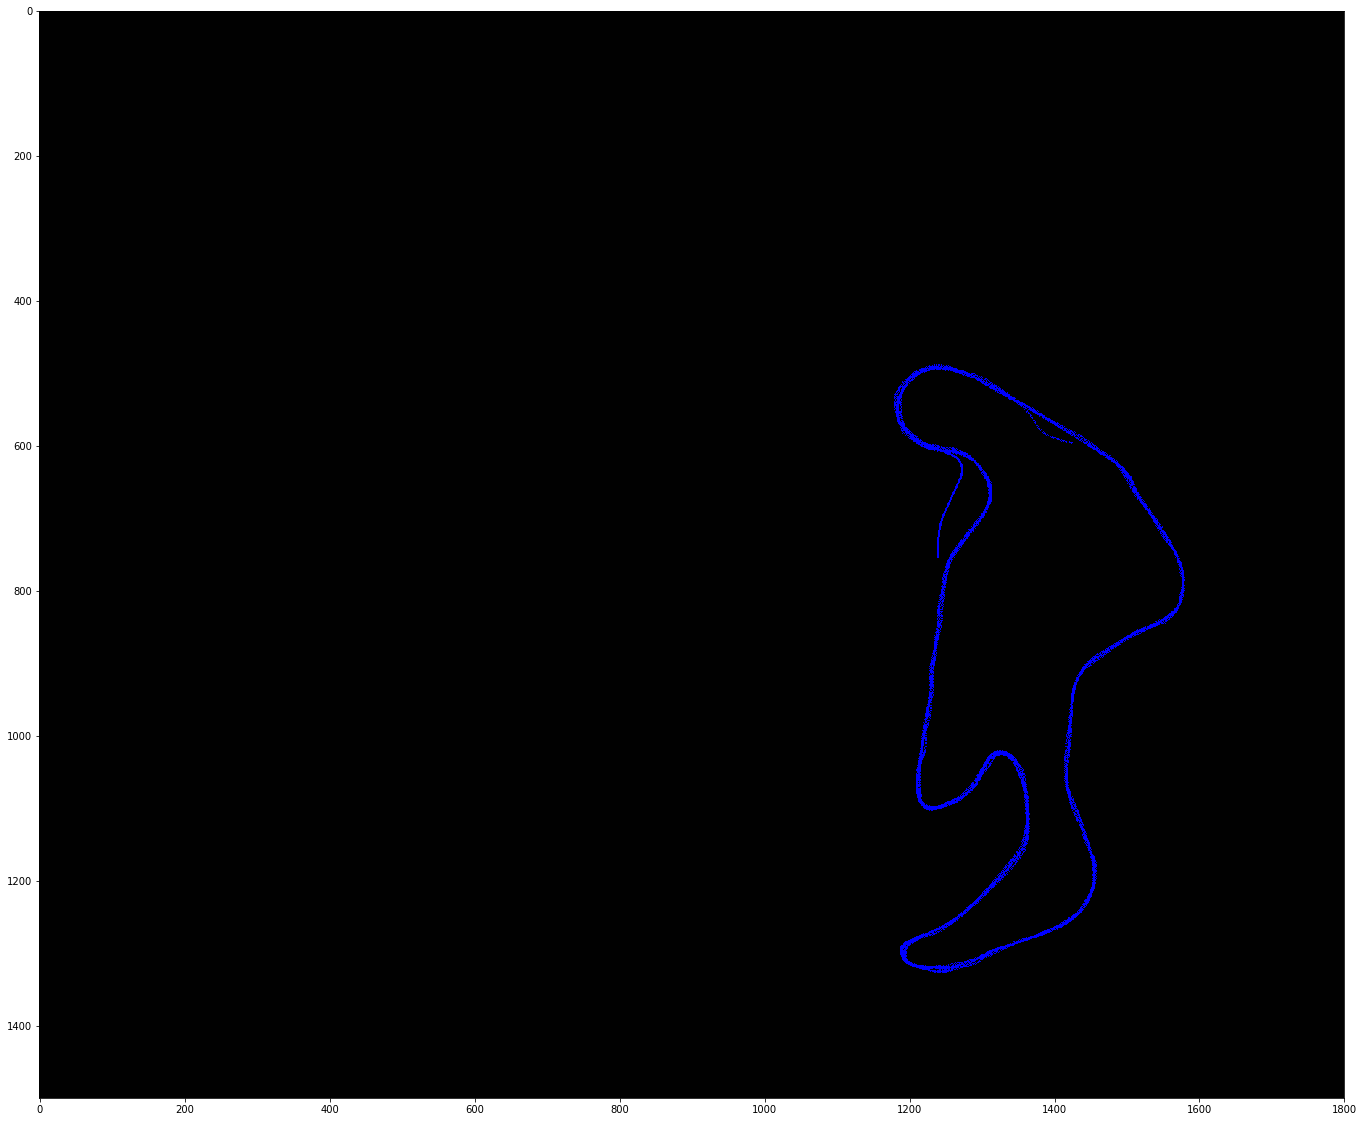

In [275]:
import cv2
img = np.ones((1500,1800, 3), np.uint8) 

#cv2.circle(img, (1240, 747), 3, (255,0,0), 3)
#cv2.circle(img, (1235, 865), 5, (255,0,0), 3)

keypoints = []

for idx, p in enumerate (position_data):
    pos = (int(p[1][4]), int(p[1][5]))
    cv2.circle(img,pos, 1, (0,0,255))
    if idx % 25 == 0:
        #cv2.circle(img, pos, 3, (255,255,0), 1)
        keypoints.append(pos)

plt.figure(figsize=(30,20))
plt.imshow(img)

In [278]:
import imageio
imageio.plugins.ffmpeg.download()
import numpy as np
import moviepy.editor as mpy
import cv2

imgcp = img.copy()
maxp = len(position_data) - 25
r=150.
x=500
y=500

def make_frame(t):
    pi = int(t * 24) % maxp
    start = get_pos(position_data[pi])
    end = get_pos(position_data[pi+25])
    #print(cur_p)
    cp_img = np.copy(imgcp)
    cv2.circle(cp_img, start, pi % 10, (255,0,0),3)
    cv2.circle(cp_img, end,5,(0,255,255), 3)
    h = get_heading(start, end)
    draw_steering(cp_img, x,y,r,h+deg2rad(90))
    
    return cp_img # returns a 8-bit RGB array

"""
s=2000
e=2025
start = (int(position_data[s][1][4]), int(position_data[s][1][5]))
end = (int(position_data[e][1][4]), int(position_data[e][1][5]))
cv2.circle(imgcp, start,5,(255,255,255), 3)
cv2.circle(imgcp, end,5,(0,255,255), 3)

sh = get_steering(position_data[s])
print(rad2deg(h), rad2deg(sh)-90)
"""

clip = mpy.VideoClip(make_frame, duration=(int(maxp/24)+1)) # 2 seconds
clip.write_videofile("steering.mp4",fps=24, codec='mpeg4')


#plt.figure(figsize=(30,20))
#plt.imshow(imgcp)

[MoviePy] >>>> Building video steering.mp4
[MoviePy] Writing video steering.mp4


100%|█████████▉| 7680/7681 [02:55<00:00, 43.66it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: steering.mp4 



In [51]:
img = np.ones((1500,1800, 3), np.uint8) 
print(len(keypoints))
prev=keypoints[0]
for kp in keypoints[1:]:
    h = get_heading(prev, kp)
    print(h)
    prev = kp

154
-1.5707963267948966
-1.4640606541457615
-1.2055948770067246
-1.1201350007142636
-1.3854483767992019
-2.231839495645584
-2.7498927141523692
-2.153535821044869
-0.9964914966201945
0.057080782406264685
0.5139196809985336
0.5597969195614243
0.5911571672160445
1.0121970114513346
1.0679531158670361
1.905533164111711
2.613518205163434
2.3281644502324985
1.6624924830547592
1.398605512271958
1.3161716606003555
1.9274164627463284
2.608436948082163
2.7770666511828583
2.860754928968591
-2.8798791511885877
-0.7531512809621947
-0.5774396161445132
-0.8658691746629081
-1.3625903772709087
-2.0050406475916978
2.3847581480311053
2.4791663597566416
-2.2730532583039036
-1.4097044222573167
-1.4275533779832097
-1.4240331305514324
-0.911167584157976
-1.4033645483243724
-2.6728945824799144
-2.1477292718123575
-0.7631795980707281
0.33242630538409745
0.4961271577883064
0.6934595045152272
1.0026915943204697
1.5814342233704384
2.6224465393432705
2.1471715473860797
1.5859466826696664
1.2924966677897851
2.270200

In [122]:
#http://stackoverflow.com/questions/27461634/calculate-distance-between-a-point-and-a-line-segment-in-latitude-and-longitude
import math
def dist(x1,y1, x2,y2, x3,y3): # x3,y3 is the point
    px = x2-x1
    py = y2-y1

    something = px*px + py*py
    
    if something == 0:
        return math.sqrt((x1-x3)*(x1-x3) + (y1-y3) * (y1-y3))

    u =  ((x3 - x1) * px + (y3 - y1) * py) / float(something)

    if u > 1:
        u = 1
    elif u < 0:
        u = 0

    x = x1 + u * px
    y = y1 + u * py

    dx = x - x3
    dy = y - y3

    dist = math.sqrt(dx*dx + dy*dy)

    return dist

def distance(p0, p1, p2): # p3 is the point
    x0, y0 = p0
    x1, y1 = p1
    x2, y2 = p2
    return dist(x0,y0,x1,y1, x2,y2)

def get_pos(p):
    return (int(p[1][4]), int(p[1][5]))

def get_steering(p):
    return float(p[1][0])

def get_rot_x(p):
    return float(p[1][7])

def get_rot_y(p):
    return float(p[1][8])

def get_rot_z(p):
    return float(p[1][9])


In [127]:
def get_cte(keypoints, p):
    prev=keypoints[0]

    mind = 1000.
    sp = ()
    cp= get_pos(p)
    cp = (cp[0], cp[1])
    for kp in keypoints[:1]:

        d = distance(prev, kp, cp)
        if(mind>d):
            mind = d
            sp = kp

        prev = kp
    print(sp, mind)
    return mind

In [119]:
distance((1239, 754), (1239, 755), (2239, 1987))

1586.7652630430248

In [129]:
maxp = len(position_data) - 15
minp = 15
for idx, p in enumerate (position_data[:100]):
    if idx< minp:
        continue
    if idx > maxp:
        break
    
    st = get_pos(position_data[idx - 10])
    ed = get_pos(position_data[idx + 10])
    
    cp= get_pos(p)
    d = distance(st, ed, cp)
    h = get_heading(cp, ed)
    cte = get_cte(keypoints, p)
    if cte>0.0:
        print(st, cp, ed, d, get_steering(p), cte, h)

(1239, 754) 2.0
(1239, 753) (1239, 752) (1239, 749) 0.0 0.1090468 2.0 -1.5707963267948966
(1239, 754) 2.0
(1239, 753) (1239, 752) (1239, 749) 0.0 0.1090468 2.0 -1.5707963267948966
(1239, 754) 3.0
(1239, 753) (1239, 751) (1239, 749) 0.0 0.1090468 3.0 -1.5707963267948966
(1239, 754) 3.0
(1239, 753) (1239, 751) (1239, 749) 0.0 0.1090468 3.0 -1.5707963267948966
(1239, 754) 3.0
(1239, 753) (1239, 751) (1239, 748) 0.0 0.1090468 3.0 -1.5707963267948966
(1239, 754) 3.0
(1239, 753) (1239, 751) (1239, 748) 0.0 0.1090468 3.0 -1.5707963267948966
(1239, 754) 3.0
(1239, 753) (1239, 751) (1239, 748) 0.0 0.0 3.0 -1.5707963267948966
(1239, 754) 4.0
(1239, 752) (1239, 750) (1239, 747) 0.0 0.0 4.0 -1.5707963267948966
(1239, 754) 4.0
(1239, 752) (1239, 750) (1239, 747) 0.0 0.0 4.0 -1.5707963267948966
(1239, 754) 4.0
(1239, 752) (1239, 750) (1239, 746) 0.0 0.0 4.0 -1.5707963267948966
(1239, 754) 5.0
(1239, 752) (1239, 749) (1239, 746) 0.0 0.0 5.0 -1.5707963267948966
(1239, 754) 5.0
(1239, 752) (1239, 749) 

9.18485099361e-15 150.0
(500, 350)


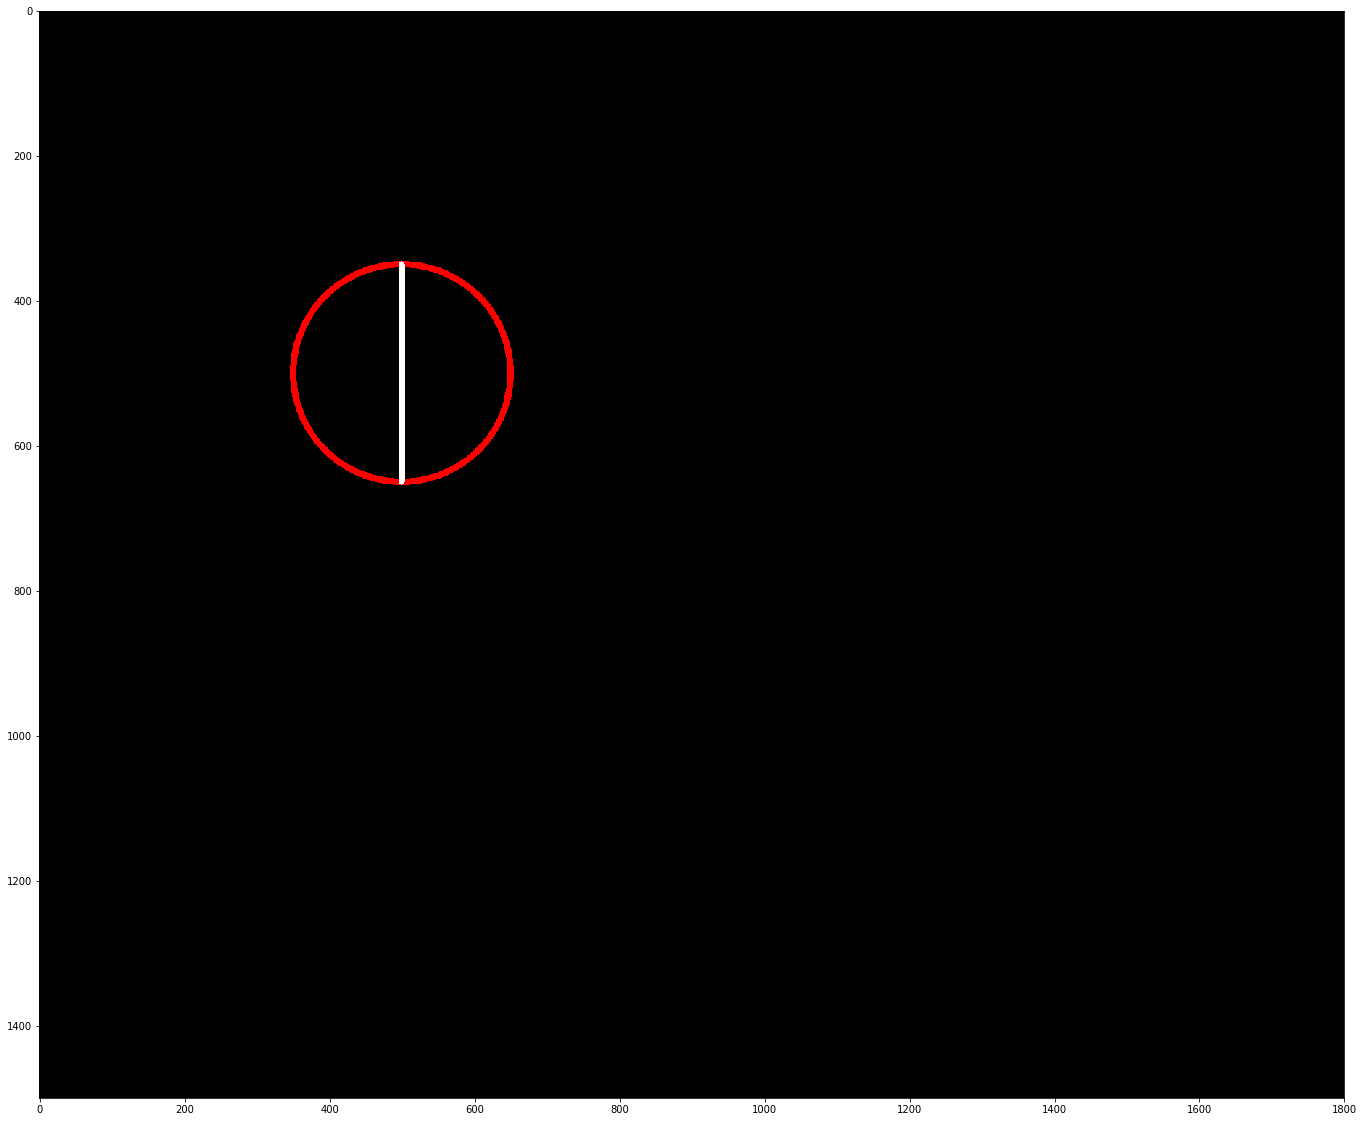

In [244]:
img = np.ones((1500,1800, 3), np.uint8) 

r=150.
x=500
y=500
theta =  -1.5707963267948966 # deg2rad(-25.)

draw_steering(img, x,y,r,theta)

plt.figure(figsize=(30,20))
plt.imshow(img)